In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Tuple, Optional


from hybrid_forecast_functions import *


In [2]:
# Demo Data Generation

# Configuration parameters
np.random.seed(42)  # For reproducibility

# Zero demand threshold for business rules
# Products with forecast values below this threshold are considered "zero demand"
# and will trigger TS prioritization in the hybrid logic
IB_ZERO_DEMAND_THRESHOLD = 0.01

# Time horizon setup
start_date = datetime(2024, 7, 16)  # Start of forecast period
end_date = start_date + timedelta(days=45)  # 45-day forecast horizon
dates = pd.date_range(start_date, end_date, freq='D')  # Daily frequency

# Hierarchy dimensions for demo data
products = [101, 102, 103, 104, 105]  # 5 test products
locations = [1, 2, 3]                # 3 test locations  
customers = [1, 2]                   # 2 test customers
distr_channels = [1]                 # 1 distribution channel


In [3]:
# Generate Short-term Reconciled Forecast Data (with both TS and ML)

reconciled_data = []

# Time Series Segment Configuration

# Each segment type has different probabilities for specific characteristics
# that drive business rule selection in hybrid forecast logic:
#
# Business Rules:
# - ML Priority: promo demand (not retired), short lifecycle, new assortment
# - TS Priority: retired products, low volume, zero/low demand
# - Ensemble: all other cases (average of TS and ML)

segments_config = {
    'Premium': {'retired_prob': 0.1, 'low_volume_prob': 0.1, 'short_prob': 0.05},
    'Standard': {'retired_prob': 0.05, 'low_volume_prob': 0.2, 'short_prob': 0.1}, 
    'Economy': {'retired_prob': 0.15, 'low_volume_prob': 0.3, 'short_prob': 0.15},
    'Luxury': {'retired_prob': 0.05, 'low_volume_prob': 0.05, 'short_prob': 0.1},
    'Retired': {'retired_prob': 1.0, 'low_volume_prob': 0.0, 'short_prob': 0.0},     # Always TS
    'Low Volume': {'retired_prob': 0.0, 'low_volume_prob': 1.0, 'short_prob': 0.0},  # Always TS
    'Short': {'retired_prob': 0.0, 'low_volume_prob': 0.0, 'short_prob': 1.0}        # Always ML
}

# Demand and assortment types that influence business rules
demand_types = ['regular', 'promo']      # Promo triggers ML priority (if not retired)
assortment_types = ['old', 'new']        # New triggers ML priority

# Generate short-term reconciled forecast data (30 days with both TS and ML forecasts)
for product in products:
    for location in locations:
        for customer in customers:
            for distr_channel in distr_channels:
                # Randomly assign a segment type for this product-location combination
                segment_name = np.random.choice(list(segments_config.keys()))
                
                # First 30 days are short-term (both TS and ML forecasts available)
                short_dates = dates[:30]
                for date in short_dates:
                    # Generate base forecast values with realistic ranges
                    ts_base = np.random.uniform(50, 200)  # TS forecast base value
                    ml_base = np.random.uniform(60, 180)  # ML forecast base value
                    
                    # Simulate missing forecasts (5% chance for TS, 10% for ML)
                    # Missing values are represented as NaN (not 0)
                    ts_val = ts_base if np.random.random() > 0.05 else np.nan
                    ml_val = ml_base if np.random.random() > 0.1 else np.nan
                    
                    # Simulate zero/low demand cases (5% chance)
                    # These will trigger TS priority in business rules
                    if np.random.random() < 0.05:
                        ts_val = np.random.uniform(0, IB_ZERO_DEMAND_THRESHOLD * 0.5)
                    
                    # Generate demand type and assortment type
                    # Promo demand (30% chance) can trigger ML priority
                    # New assortment (20% chance) can trigger ML priority
                    demand_type = np.random.choice(demand_types, p=[0.7, 0.3])
                    assortment_type = np.random.choice(assortment_types, p=[0.8, 0.2])
                    
                    reconciled_data.append({
                        'product_lvl_id': product,
                        'location_lvl_id': location,
                        'customer_lvl_id': customer,
                        'distr_channel_lvl_id': distr_channel,
                        'PERIOD_DT': date,
                        'PERIOD_END_DT': date,
                        'TS_FORECAST_VALUE_REC': ts_val,           # Reconciled TS forecast
                        'SEGMENT_NAME': segment_name,              # Determines business rules
                        'DEMAND_TYPE': demand_type,                # regular/promo affects rules
                        'ASSORTMENT_TYPE': assortment_type,        # old/new affects rules
                        'ML_FORECAST_VALUE': ml_val                # ML forecast (can be NaN)
                    })

# Convert to DataFrame and display sample
reconciled_forecast = pd.DataFrame(reconciled_data)
print(f"Generated {len(reconciled_forecast)} short-term forecast records")
reconciled_forecast.head()


Generated 900 short-term forecast records


,product_lvl_id,location_lvl_id,customer_lvl_id,distr_channel_lvl_id,PERIOD_DT,PERIOD_END_DT,TS_FORECAST_VALUE_REC,SEGMENT_NAME,DEMAND_TYPE,ASSORTMENT_TYPE,ML_FORECAST_VALUE
0,101,1,1,1,2024-07-16,2024-07-16,169.481448,Short,regular,old,82.012175
1,101,1,1,1,2024-07-17,2024-07-17,100.056292,Short,promo,old,NaN
2,101,1,1,1,2024-07-18,2024-07-18,0.002624,Short,regular,old,NaN
3,101,1,1,1,2024-07-19,2024-07-19,196.063328,Short,promo,old,87.932561
4,101,1,1,1,2024-07-20,2024-07-20,178.991061,Short,regular,old,NaN


In [4]:
# Generate Mid-term Reconciled Forecast Data (TS-only beyond day 30)

mid_reconciled_data = []

# Mid-term period: days 31-45 (ML forecasts not available, only TS)
mid_dates = dates[30:]

for product in products:
    for location in locations:
        for customer in customers:
            for distr_channel in distr_channels:
                # For mid-term, use only stable segments (no retired/short/low volume)
                # since these are longer-term forecasts
                segment_name = np.random.choice(['Premium', 'Standard', 'Economy'])
                
                for date in mid_dates:
                    # Only TS forecasts available for mid-term period
                    # ML models typically don't forecast this far out
                    ts_val = np.random.uniform(40, 150)
                    
                    mid_reconciled_data.append({
                        'product_lvl_id': product,
                        'location_lvl_id': location,
                        'customer_lvl_id': customer,
                        'distr_channel_lvl_id': distr_channel,
                        'PERIOD_DT': date,
                        'PERIOD_END_DT': date,
                        'TS_FORECAST_VALUE_REC': ts_val,     # Only TS forecast available
                        'SEGMENT_NAME': segment_name,        # Stable segments for mid-term
                        'DEMAND_TYPE': 'regular',            # No promos in mid-term
                        'ASSORTMENT_TYPE': 'old',            # No new products in mid-term
                        'ML_FORECAST_VALUE': np.nan          # ML forecasts not available
                    })

# Convert to DataFrame
mid_reconciled_forecast = pd.DataFrame(mid_reconciled_data)
print(f"Generated {len(mid_reconciled_forecast)} mid-term forecast records")


Generated 480 mid-term forecast records


In [5]:
# Execute Hybrid Forecast Generation Pipeline

# Run the complete hybrid forecast generation process:
# 1. Apply business rules to short-term data (TS + ML)
# 2. Process mid-term data (TS only)  
# 3. Combine both periods into unified hybrid forecast

hybrid_forecast = hybrid_forecast_generation_pipeline(
    reconciled_forecast=reconciled_forecast,        # Short-term with TS+ML
    mid_reconciled_forecast=mid_reconciled_forecast, # Mid-term with TS only
    ib_zero_demand_threshold=IB_ZERO_DEMAND_THRESHOLD # Zero demand threshold
)

print(f"Generated {len(hybrid_forecast)} hybrid forecast records")
print("\nHybrid forecast columns:", hybrid_forecast.columns.tolist())
print("\nForecast source distribution:")
print(hybrid_forecast['FORECAST_SOURCE'].value_counts())
hybrid_forecast.head()


Generated 1380 hybrid forecast records

Hybrid forecast columns: ['product_lvl_id', 'location_lvl_id', 'customer_lvl_id', 'distr_channel_lvl_id', 'PERIOD_DT', 'PERIOD_END_DT', 'TS_FORECAST_VALUE', 'SEGMENT_NAME', 'DEMAND_TYPE', 'ASSORTMENT_TYPE', 'ML_FORECAST_VALUE', 'HYBRID_FORECAST_VALUE', 'ENSEMBLE_FORECAST_VALUE', 'FORECAST_SOURCE']

Forecast source distribution:
FORECAST_SOURCE
ts          677
ml          472
ensemble    231
Name: count, dtype: int64


,product_lvl_id,location_lvl_id,customer_lvl_id,distr_channel_lvl_id,PERIOD_DT,PERIOD_END_DT,TS_FORECAST_VALUE,SEGMENT_NAME,DEMAND_TYPE,ASSORTMENT_TYPE,ML_FORECAST_VALUE,HYBRID_FORECAST_VALUE,ENSEMBLE_FORECAST_VALUE,FORECAST_SOURCE
0,101,1,1,1,2024-07-16,2024-07-16,169.481448,Short,regular,old,82.012175,82.012175,NaN,ml
1,101,1,1,1,2024-07-17,2024-07-17,100.056292,Short,promo,old,NaN,100.056292,NaN,ml
2,101,1,1,1,2024-07-18,2024-07-18,0.002624,Short,regular,old,NaN,0.002624,NaN,ml
3,101,1,1,1,2024-07-19,2024-07-19,196.063328,Short,promo,old,87.932561,87.932561,NaN,ml
4,101,1,1,1,2024-07-20,2024-07-20,178.991061,Short,regular,old,NaN,178.991061,NaN,ml


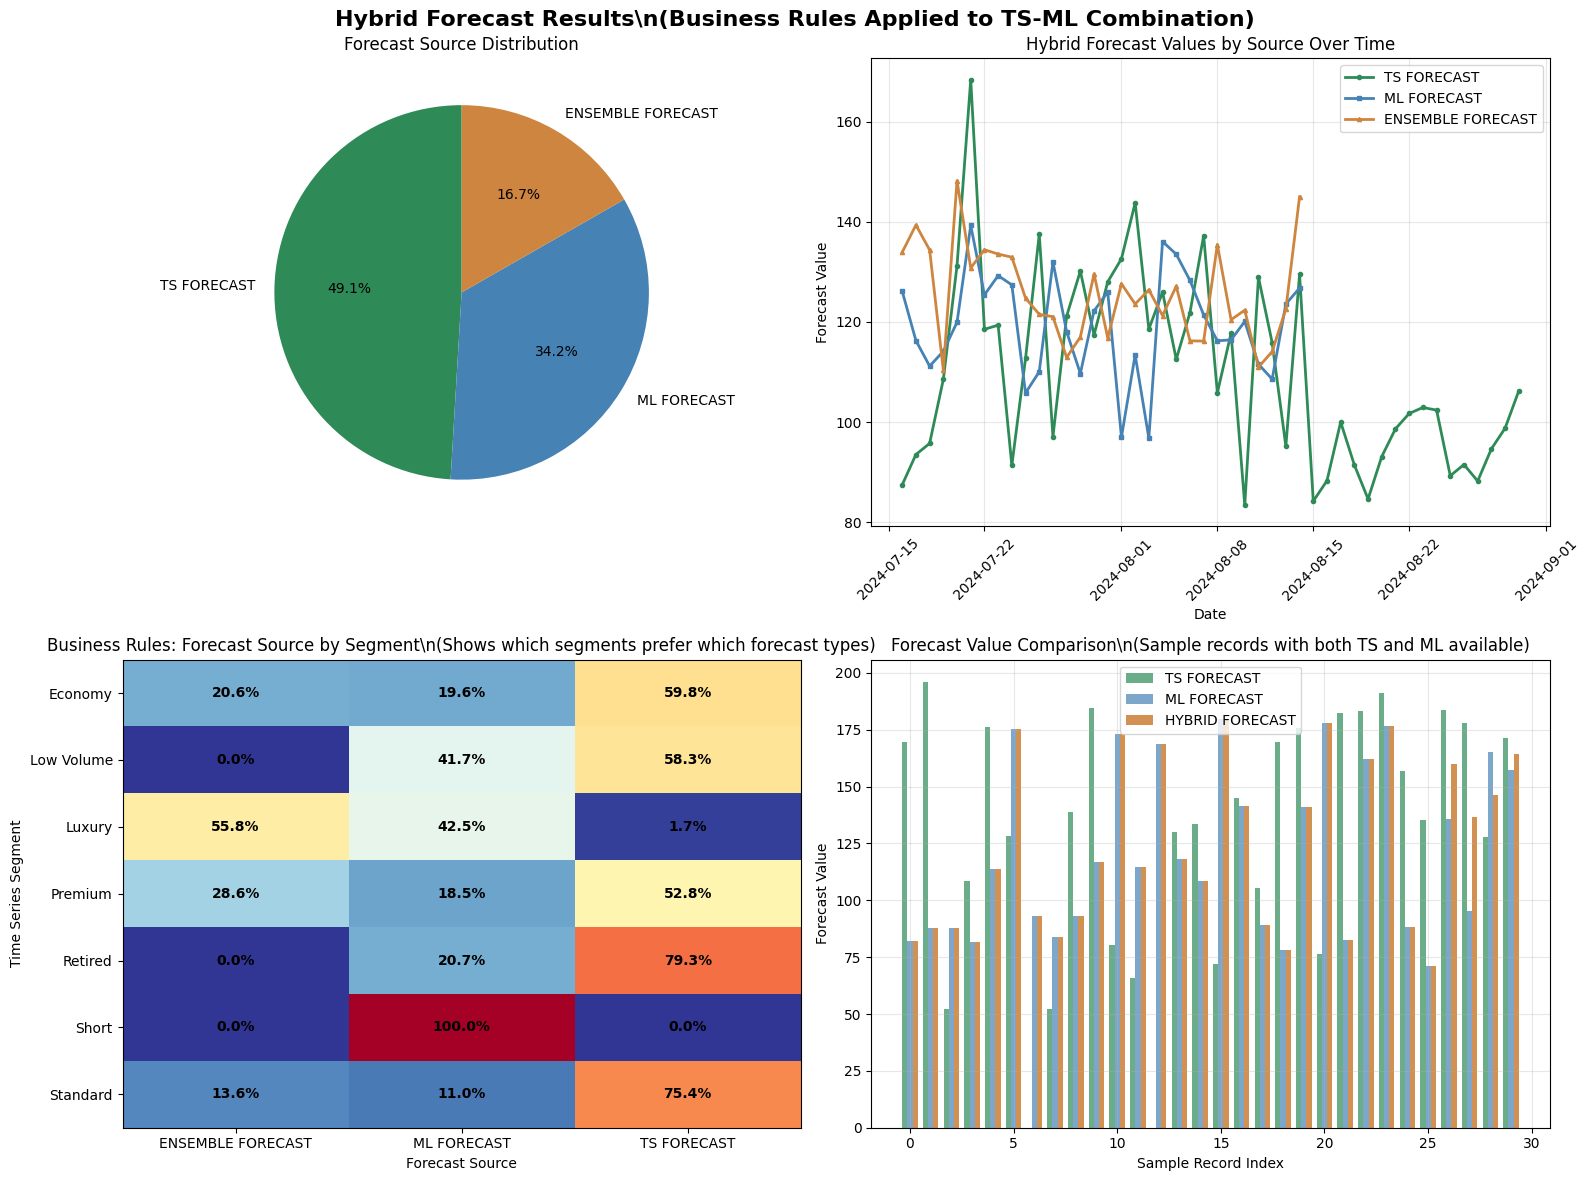

In [6]:
# Visualization: Hybrid Forecast Analysis

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Hybrid Forecast Results\\n(Business Rules Applied to TS-ML Combination)', 
             fontsize=16, fontweight='bold')

# 1. Source distribution pie chart
ax1 = axes[0, 0]
source_counts = hybrid_forecast['FORECAST_SOURCE'].value_counts()
colors = ['#2E8B57', '#4682B4', '#CD853F']
source_labels = [f'{src.upper()} FORECAST' for src in source_counts.index]
ax1.pie(source_counts.values, labels=source_labels, 
       autopct='%1.1f%%', colors=colors[:len(source_counts)], startangle=90)
ax1.set_title('Forecast Source Distribution')

# 2. Time series comparison by source
ax2 = axes[0, 1]
# Fill with NaN instead of 0 for proper visualization of missing data
time_series = hybrid_forecast.groupby(['PERIOD_DT', 'FORECAST_SOURCE'])['HYBRID_FORECAST_VALUE'].mean().unstack(fill_value=np.nan)

if 'ts' in time_series.columns:
    ax2.plot(time_series.index, time_series['ts'], label='TS FORECAST', 
            color='#2E8B57', linewidth=2, marker='o', markersize=3)
if 'ml' in time_series.columns:
    ax2.plot(time_series.index, time_series['ml'], label='ML FORECAST', 
            color='#4682B4', linewidth=2, marker='s', markersize=3)
if 'ensemble' in time_series.columns:
    ax2.plot(time_series.index, time_series['ensemble'], label='ENSEMBLE FORECAST', 
            color='#CD853F', linewidth=2, marker='^', markersize=3)

ax2.set_title('Hybrid Forecast Values by Source Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Forecast Value')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Business rules heatmap showing which segments use which forecast sources
ax3 = axes[1, 0]
segment_source_pct = pd.crosstab(hybrid_forecast['SEGMENT_NAME'], 
                                hybrid_forecast['FORECAST_SOURCE'], 
                                normalize='index') * 100

im = ax3.imshow(segment_source_pct.values, cmap='RdYlBu_r', aspect='auto')
ax3.set_xticks(range(len(segment_source_pct.columns)))
ax3.set_yticks(range(len(segment_source_pct.index)))
# Add "FORECAST" to column labels
forecast_labels = [f'{col.upper()} FORECAST' for col in segment_source_pct.columns]
ax3.set_xticklabels(forecast_labels)
ax3.set_yticklabels(segment_source_pct.index)

# Add percentage values to each cell
for i in range(len(segment_source_pct.index)):
    for j in range(len(segment_source_pct.columns)):
        ax3.text(j, i, f'{segment_source_pct.iloc[i, j]:.1f}%',
                ha="center", va="center", color="black", fontweight='bold')

ax3.set_title('Business Rules: Forecast Source by Segment\\n(Shows which segments prefer which forecast types)')
ax3.set_xlabel('Forecast Source')
ax3.set_ylabel('Time Series Segment')

# 4. Forecast value comparison (sample data)
ax4 = axes[1, 1]
# Select sample data where both TS and ML forecasts exist (not NaN)
sample_data = hybrid_forecast.dropna(subset=['TS_FORECAST_VALUE', 'ML_FORECAST_VALUE']).head(30)

if len(sample_data) > 0:
    x_pos = np.arange(len(sample_data))
    width = 0.25
    
    # Show all three forecast types with proper labels
    ax4.bar(x_pos - width, sample_data['TS_FORECAST_VALUE'], width, 
           label='TS FORECAST', color='#2E8B57', alpha=0.7)
    ax4.bar(x_pos, sample_data['ML_FORECAST_VALUE'], width, 
           label='ML FORECAST', color='#4682B4', alpha=0.7)
    ax4.bar(x_pos + width, sample_data['HYBRID_FORECAST_VALUE'], width, 
           label='HYBRID FORECAST', color='#CD853F', alpha=0.9)
    
    ax4.set_title('Forecast Value Comparison\\n(Sample records with both TS and ML available)')
    ax4.set_xlabel('Sample Record Index')
    ax4.set_ylabel('Forecast Value')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No records with both\\nTS and ML forecasts available', 
             ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Forecast Value Comparison')

plt.tight_layout()
plt.show()


In [7]:
# Business Rules Validation and Quality Checks

print("=== HYBRID FORECAST VALIDATION SUMMARY ===")
print(f"Total records generated: {len(hybrid_forecast)}")
print(f"Date range: {hybrid_forecast['PERIOD_DT'].min()} to {hybrid_forecast['PERIOD_DT'].max()}")

# Check forecast source distribution
source_dist = hybrid_forecast['FORECAST_SOURCE'].value_counts()
print(f"\nForecast source distribution:")
for source, count in source_dist.items():
    percentage = (count / len(hybrid_forecast)) * 100
    print(f"  {source.upper()} FORECAST: {count} records ({percentage:.1f}%)")

# Validate ML Priority Business Rules
print(f"\n=== BUSINESS RULES VALIDATION ===")
print("ML Priority Rules: Use ML forecast when...")
print("  - Promotional demand (not retired)")
print("  - Short lifecycle segments") 
print("  - New assortment products")

ml_priority_mask = (
    ((hybrid_forecast['DEMAND_TYPE'].str.lower() == 'promo') & 
     (hybrid_forecast['SEGMENT_NAME'].str.lower() != 'retired')) |
    (hybrid_forecast['SEGMENT_NAME'].str.lower() == 'short') |
    (hybrid_forecast['ASSORTMENT_TYPE'].str.lower() == 'new')
)
ml_correct = (hybrid_forecast[ml_priority_mask]['FORECAST_SOURCE'] == 'ml').sum()
ml_accuracy = (ml_correct / ml_priority_mask.sum() * 100) if ml_priority_mask.sum() > 0 else 0
print(f"ML rule accuracy: {ml_correct}/{ml_priority_mask.sum()} ({ml_accuracy:.1f}%)")

# Validate TS Priority Business Rules
print("\nTS Priority Rules: Use TS forecast when...")
print("  - Retired products")
print("  - Low volume segments")
print(f"  - Zero/low demand (≤ {IB_ZERO_DEMAND_THRESHOLD})")

ts_priority_mask = (
    (hybrid_forecast['SEGMENT_NAME'].str.lower() == 'retired') |
    (hybrid_forecast['SEGMENT_NAME'].str.lower() == 'low volume') |
    (hybrid_forecast['TS_FORECAST_VALUE'] <= IB_ZERO_DEMAND_THRESHOLD)
)
ts_correct = (hybrid_forecast[ts_priority_mask]['FORECAST_SOURCE'] == 'ts').sum()
ts_accuracy = (ts_correct / ts_priority_mask.sum() * 100) if ts_priority_mask.sum() > 0 else 0
print(f"TS rule accuracy: {ts_correct}/{ts_priority_mask.sum()} ({ts_accuracy:.1f}%)")

# Check for missing values (should be NaN, not 0)
print(f"\n=== DATA QUALITY CHECKS ===")
nan_ml = hybrid_forecast['ML_FORECAST_VALUE'].isna().sum()
nan_ensemble = hybrid_forecast['ENSEMBLE_FORECAST_VALUE'].isna().sum()
print(f"ML_FORECAST_VALUE: {nan_ml} NaN values (appropriate for mid-term periods)")
print(f"ENSEMBLE_FORECAST_VALUE: {nan_ensemble} NaN values (appropriate when using single source)")

# Ensemble validation (should only have values when source='ensemble')
ensemble_records = hybrid_forecast[hybrid_forecast['FORECAST_SOURCE'] == 'ensemble']
ensemble_with_values = ensemble_records['ENSEMBLE_FORECAST_VALUE'].notna().sum()
print(f"Ensemble forecast values: {ensemble_with_values}/{len(ensemble_records)} ensemble records have values")


=== HYBRID FORECAST VALIDATION SUMMARY ===
Total records generated: 1380
Date range: 2024-07-16 00:00:00 to 2024-08-30 00:00:00

Forecast source distribution:
  TS FORECAST: 677 records (49.1%)
  ML FORECAST: 472 records (34.2%)
  ENSEMBLE FORECAST: 231 records (16.7%)

=== BUSINESS RULES VALIDATION ===
ML Priority Rules: Use ML forecast when...
  - Promotional demand (not retired)
  - Short lifecycle segments
  - New assortment products
ML rule accuracy: 472/472 (100.0%)

TS Priority Rules: Use TS forecast when...
  - Retired products
  - Low volume segments
  - Zero/low demand (≤ 0.01)
TS rule accuracy: 197/295 (66.8%)

=== DATA QUALITY CHECKS ===
ML_FORECAST_VALUE: 565 NaN values (appropriate for mid-term periods)
ENSEMBLE_FORECAST_VALUE: 1151 NaN values (appropriate when using single source)
Ensemble forecast values: 229/231 ensemble records have values
